In [1]:
%matplotlib nbagg
%load_ext line_profiler
%load_ext autoreload

In [2]:
import math

import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import scipy.sparse
import sparse
import numba

In [3]:
from libertem import api
from libertem.executor.inline import InlineJobExecutor
from libertem.udf.backend import set_use_cuda, set_use_cpu, get_backend
from libertem.common.container import MaskContainer

In [4]:
from ptychography.reconstruction.ssb import SSB_UDF, wavelength, generate_masks

In [5]:
ctx = api.Context(executor=InlineJobExecutor())
# ctx = api.Context()

In [28]:
set_use_cuda(0)
# set_use_cpu(0)

In [7]:
ctx.executor.client.scheduler_info()

AttributeError: 'InlineJobExecutor' object has no attribute 'client'

In [8]:
def reference_ssb(data, U, dpix, semiconv, semiconv_pix, cy=None, cx=None):

    # 'U' - The acceleration voltage U in keV
    # 'dpix' - STEM pixel size in m
    # 'semiconv' -  STEM semiconvergence angle in radians
    # 'semiconv_pix' - Diameter of the primary beam in the diffraction pattern in pixels

    reordered = np.moveaxis(data, (0, 1), (2, 3))
    ffts = np.fft.fft2(reordered)
    rearranged_ffts = np.moveaxis(ffts, (2, 3), (0, 1))

    Nblock = np.array(data.shape[0:2])
    Nscatter = np.array(data.shape[2:4])

    # electron wavelength in m
    lamb = wavelength(U)
    # spatial freq. step size in scattering space
    d_Kf = np.sin(semiconv)/lamb/semiconv_pix
    # spatial freq. step size according to probe raster
    d_Qp = 1/dpix/Nblock

    result_f = np.zeros(data.shape[:2], dtype=rearranged_ffts.dtype)

    masks = np.zeros_like(data)

    if cx is None:
        cx = data.shape[-1] / 2
    if cy is None:
        cy = data.shape[-2] / 2

    y, x = np.ogrid[0:Nscatter[0], 0:Nscatter[1]]
    filter_center = (y - cy)**2 + (x - cx)**2 < semiconv_pix**2

    for q in range(Nblock[0]):
        for p in range(Nblock[1]):
            qp = np.array((q, p))
            flip = qp > Nblock / 2
            real_qp = qp.copy()
            real_qp[flip] = qp[flip] - Nblock[flip]

            sx, sy = real_qp * d_Qp / d_Kf

            filter_positive = (y - cy - sy)**2 + (x - cx - sx)**2 < semiconv_pix**2
            filter_negative = (y - cy + sy)**2 + (x - cx + sx)**2 < semiconv_pix**2

            mask_positive = np.all((filter_center, filter_positive,
                                    np.invert(filter_negative)), axis=0)
            mask_negative = np.all((filter_center, filter_negative,
                                    np.invert(filter_positive)), axis=0)

            f = rearranged_ffts[q, p]

            non_zero_positive = np.count_nonzero(mask_positive)
            non_zero_negative = np.count_nonzero(mask_negative)

            if non_zero_positive > 0 and non_zero_negative > 0:
                result_f[q, p] = (np.average(f[mask_positive]) - np.average(f[mask_negative])) / 2
                masks[q, p] = ((mask_positive / non_zero_positive) - (
                               mask_negative / non_zero_negative)) / 2
                assert np.allclose(result_f[q, p], (f*masks[q, p]).sum())
            else:
                assert non_zero_positive == 0
                assert non_zero_negative == 0

    result_f[0, 0] = np.average(rearranged_ffts[0, 0, filter_center])
    masks[0, 0] = filter_center / np.count_nonzero(filter_center)

    return result_f, masks

In [34]:
path = r'/cachedata/users/weber/data/CBED_MSAP.raw'
dtype = np.float32

shape = (50, 50, 189, 189)
#  ? shape = np.random.uniform(1, 300, (4,1,))

reconstruct_shape = (shape[0] // 2, shape[1] // 2)

# The acceleration voltage U in keV
U = 300
# STEM pixel size in m, here 50 STEM pixels on 0.5654 nm
dpix = 0.5654/50*1e-9 
# STEM semiconvergence angle in radians
semiconv = 25e-3
# Diameter of the primary beam in the diffraction pattern in pixels
semiconv_pix = 78.6649

cy = 189 // 2
cx = 189 // 2

In [10]:
input_data = np.memmap(path, dtype=np.float32, shape=shape, mode='r')

In [11]:
ds = ctx.load("raw", path=path, dtype=np.float32, scan_size=shape[:2], detector_size=shape[2:])

In [12]:
# dtype = np.float32
# scale = 4
# shape = (66, 67, 189 // scale, 190 // scale)
# reconstruct_shape = (shape[0], shape[1])
# #  ? shape = np.random.uniform(1, 300, (4,1,))

# # The acceleration voltage U in keV
# U = 300
# # STEM pixel size in m, here 50 STEM pixels on 0.5654 nm
# dpix = 0.5654/50*1e-9 
# # STEM semiconvergence angle in radians
# semiconv = 25e-3
# # Diameter of the primary beam in the diffraction pattern in pixels
# semiconv_pix = 78.6649 / scale

# cy = 91 // scale
# cx = 95 // scale

In [13]:
# input_data = np.random.uniform(0, 1, shape)

In [14]:
# ds = ctx.load("memory", data=input_data)

In [15]:
%%time
result_f, reference_masks = reference_ssb(input_data, U, dpix, semiconv, semiconv_pix, cy, cx)

CPU times: user 3.7 s, sys: 1.25 s, total: 4.95 s
Wall time: 4.95 s


In [41]:
%%time
masks = generate_masks(
    reconstruct_shape=reconstruct_shape, mask_shape=shape[2:],
    dtype=dtype,
    wavelength=wavelength(U),
    dpix=dpix,
    semiconv=semiconv,
    semiconv_pix=semiconv_pix,
    center=(cy, cx),
)

mask_container = MaskContainer(
    mask_factories=lambda: masks, dtype=masks.dtype,
    use_sparse='scipy.sparse.csr', count=masks.shape[0], backend=get_backend()
)

Mask factory size 18666532 larger than warning limit 1048576, may be inefficient


CPU times: user 145 ms, sys: 20.8 ms, total: 166 ms
Wall time: 165 ms


In [42]:
%autoreload
udf = SSB_UDF(
    U=U, dpix=dpix, semiconv=semiconv, semiconv_pix=semiconv_pix,
    dtype=dtype, center=(cy, cx), reconstruct_shape=reconstruct_shape,
    mask_container=mask_container,
)

In [43]:
%%time
udf_result = ctx.run_udf(udf=udf, dataset=ds)

CPU times: user 947 ms, sys: 616 ms, total: 1.56 s
Wall time: 1.56 s


In [22]:
np.allclose(udf_result['pixels'].data, result_f)

False

In [253]:
%lprun -f generate_masks -f SSB_UDF.get_task_data -f SSB_UDF.process_tile ctx.run_udf(udf=udf, dataset=ds)

Mask factory size 37083658 larger than warning limit 1048576, may be inefficient
Mask factory size 37083658 larger than warning limit 1048576, may be inefficient


<IPython.core.display.Javascript object>


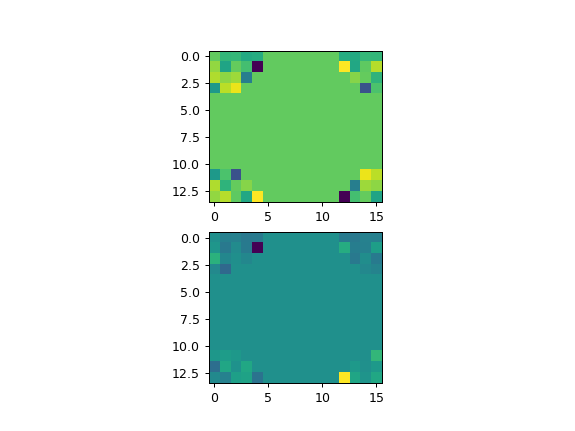

In [202]:
fig, axes = plt.subplots(2)
axes[0].imshow(np.imag(result_f))
axes[1].imshow(np.imag(udf_result['pixels'].data))

In [221]:
mask_stack = reference_masks[:shape[0] // 2 + 1].reshape((-1, shape[2]*shape[3])).T.copy()


def simple_test(roi, data):
    tiledepth = 23
    num_tiles = len(data) // tiledepth
    result = np.zeros(shape[:2], dtype=np.complex128)

    y_positions, x_positions = np.mgrid[0:shape[0], 0:shape[1]]
    y_map = y_positions[roi]
    x_map = x_positions[roi]
    
    
    half_y = shape[0] // 2 + 1
    
    q_steps = -2j*np.pi*np.linspace(0, 1, shape[0], endpoint=False)[:half_y]
    p_steps = -2j*np.pi*np.linspace(0, 1, shape[1], endpoint=False)
    
    def process_tile(tile, tile_start):
        tile_depth = tile.shape[0]
        y_indices = y_map[tile_start:tile_start+tile_depth]
        x_indices = x_map[tile_start:tile_start+tile_depth]
        
        dot_result = np.dot(tile.reshape(tile_depth, -1), mask_stack).reshape((tile_depth, half_y, shape[1]))
        fourier_factors_q = np.exp(y_indices[:, np.newaxis, np.newaxis] * q_steps[np.newaxis, :, np.newaxis])
        fourier_factors_p = np.exp(x_indices[:, np.newaxis, np.newaxis] * p_steps[np.newaxis, np.newaxis, :])
        
        buffer_frame = np.zeros_like(result)
        buffer_frame[:half_y] = (dot_result*fourier_factors_q*fourier_factors_p).sum(axis=0)
        # Account for even and odd sizes
        # FIXME make sure this is correct using an example that transmits also the high spatial frequencies
        patch = (shape[0]) % 2
        # We skip the first row since it would be outside the FOV
        extracted = buffer_frame[1:shape[0] // 2 + patch]
        # The coordinates of the bottom half are inverted and
        # the zero column is rolled around to the front
        # The real part is inverted
        buffer_frame[shape[0] // 2 + 1:] = -np.conjugate(np.roll(np.flip(extracted), shift=1, axis=1))
        return buffer_frame
    
    for tile in range(num_tiles):
        start = tile*tiledepth
        tile = data[start:start+tiledepth]
        result += process_tile(tile, start)
    remaining_tile = data[num_tiles*tiledepth:]
    result += process_tile(remaining_tile, num_tiles*tiledepth)
            
    return result

In [225]:
%%time
roi_1 = np.random.choice([True, False], shape[:2])
roi_2 = np.invert(roi_1)

roi_all = np.ones(shape[:2], dtype=bool)
result = simple_test(roi_1, input_data[roi_1]) + simple_test(roi_2, input_data[roi_2])
# result = simple_test(roi_all, input_data[roi_all])

Wall time: 14 ms


In [226]:
np.allclose(result_f, result)

True

<IPython.core.display.Javascript object>


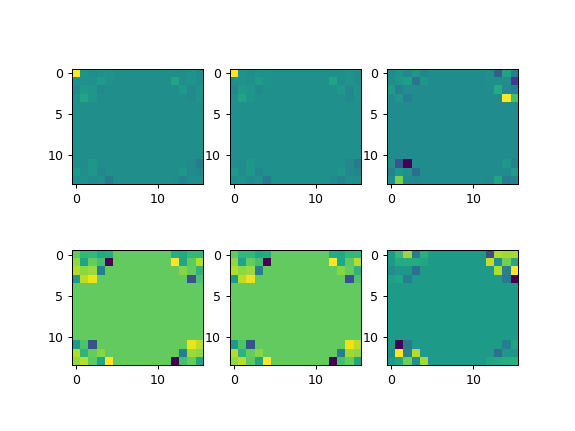

In [227]:
fig, axes = plt.subplots(2, 3)
axes[0, 0].imshow(np.real(result_f), vmin=-5, vmax=5)
axes[0, 1].imshow(np.real(result), vmin=-5, vmax=5)
axes[0, 2].imshow(np.real(result - result_f))
axes[1, 0].imshow(np.imag(result_f))
axes[1, 1].imshow(np.imag(result))
axes[1, 2].imshow(np.imag(result - result_f))


In [220]:
8 * 16

128

In [229]:
(1-1j)*-1

(-1+1j)